In [1]:
from scipy.integrate import solve_ivp
from scipy.stats import gamma as gamma_dist
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
import sys
sys.path.append("../code")
import model
import model_ramp
import model_logistic
import plotting
import plotting2
import parametros

In [3]:
params_model = parametros.params.copy()
params_model.update({'u_base':0.25})

params_model_ramp = params_model.copy()
params_model_logistic = params_model.copy()

params_model_ramp.update( {'epsilon_u':0.1, 'epsilon_w':0.1} )
params_model_logistic.update( {'r_base':0.015} )

In [4]:
m0 = model.Model(**params_model)
mR = model_ramp.Model(**params_model_ramp)
mL = model_logistic.Model(**params_model_logistic)

In [5]:
times, data = m0.run()
times, data = mR.run()
times, data = mL.run()

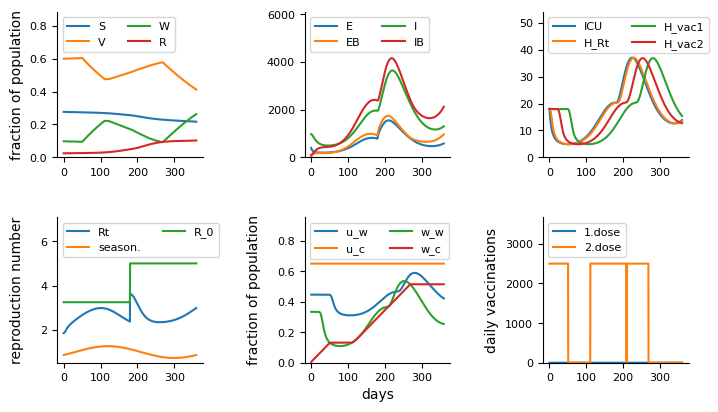

In [6]:
plotting.overview(m0)

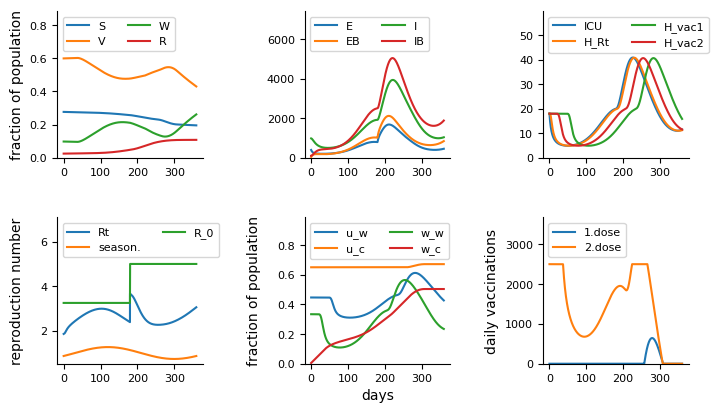

In [7]:
plotting.overview(mR)

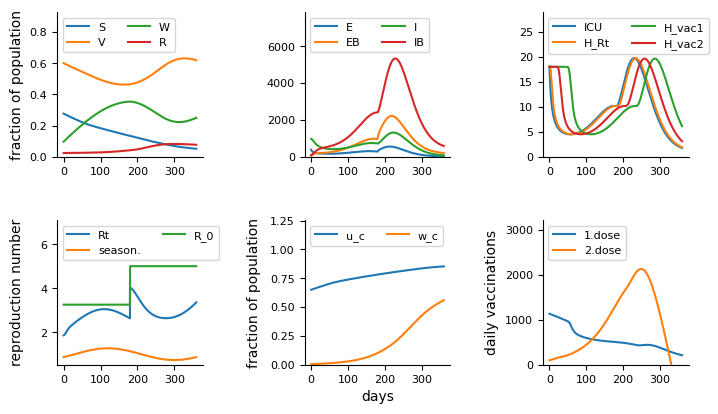

In [8]:
plotting2.overview(mL)

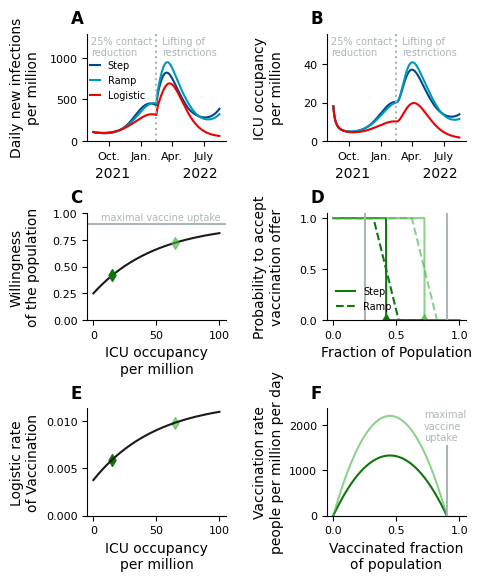

In [27]:
plotting.set_rcParams(arial=True)
mpl.rcParams["legend.fontsize"] = 7
fig = plt.figure(figsize=(7*2/3., 3*1.9), constrained_layout=True)
grid = fig.add_gridspec(ncols=2, nrows=3, wspace=0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1], sharex=ax1)
ax3 = fig.add_subplot(grid[2])
ax4 = fig.add_subplot(grid[3])
ax5 = fig.add_subplot(grid[4], sharex=ax3)
ax6 = fig.add_subplot(grid[5], sharex=ax4)

colors = {
    'step':'#00468BFF', 'ramp':'#0099B4FF', 'log':'#ED0000FF',
    'icu':'#1B1919FF', 'icuL':'#1B191999',
    'scen1':'#10750FFF', 'scen2':'#42B54099',
    'line':'#ADB6B6FF',
    'vac':'#925E9FFF'
}

main_colors = [colors['step'],colors['ramp'],colors['log']]

t = m0.times
data = [m0.chopped_data(), mR.chopped_data(), mL.chopped_data()]

for i,m in enumerate([m0,mR,mL]):
    ax1.plot(t, m.rho*(data[i][:,3]+data[i][:,4]), color=main_colors[i])
    ax2.plot(t, data[i][:,7], color=main_colors[i])

for i,m in enumerate([m0,mR]):
    d1 = np.array(list(map(m.Phi, t, data[i][:,9])))*m.M
    d2 = np.array(list(map(m.phi, t, data[i][:,10])))*m.M

def u_w(H):
    return m0.u_base + (m0.u_max-m0.u_base)*(1-np.exp(-m0.alpha_u*H-m0.e_u))
def w_w(H):
    return m0.w_max*(1-np.exp(-m0.alpha_w*H-m0.e_w))

scen1 = 15
scen2 = 65

x = np.linspace(0,100,1000)
ax3.plot(x,list(map(u_w,x)), color=colors['icu'], label='1.Dose')
#ax3.plot(x,list(map(w_w,x)), color=colors['icuL'], label='2.Dose')
ax3.scatter(scen1,u_w(scen1), marker='d', color=colors['scen1'], zorder=2.5)
ax3.scatter(scen2,u_w(scen2), marker='d', color=colors['scen2'], zorder=2.5)
ax3.axhline(1-mR.chi_0, color=colors['line'])

def step(H, x):
    return 0 if x>u_w(H) else 1
def ramp(H, x):
    return 0 if x>(u_w(H)+mR.epsilon_u) else min( (u_w(H)-x+mR.epsilon_u)/2./mR.epsilon_u, 1)
#   if u_w(H) < (UC/mR.M - mR.epsilon_u): return 0
#   if u_w(H) > (UC/mR.M + mR.epsilon_u): return mR.Phi_0
#   return (u_w(H) - UC/mR.M + mR.epsilon_u)/2./mR.epsilon_u * mR.Phi_0

x = np.linspace(0,1,1000)
ax4.plot(x,list(map(step, np.ones(1000)*scen1, x)), color=colors['scen1'], label='Step')
ax4.plot(x,list(map(ramp, np.ones(1000)*scen1, x)), color=colors['scen1'], ls='--', label='Ramp')
ax4.plot(x,list(map(step, np.ones(1000)*scen2, x)), color=colors['scen2'])
ax4.plot(x,list(map(ramp, np.ones(1000)*scen2, x)), color=colors['scen2'], ls='--')
ax4.scatter(u_w(scen1),0, marker='d', color=colors['scen1'])
ax4.scatter(u_w(scen2),0, marker='d', color=colors['scen2'])

#ax4.axvline(0.45, color=colors['vac'])
ax4.axvline(mR.u_base, color=colors['line'])
ax4.axvline(1-mR.chi_0, color=colors['line'])

def Phi_2(H):
    r_icu = 4*mL.Phi_0/(1-mL.chi_0)*(1-np.exp(-mL.alpha_u*H))
    return 0.25*mL.r_base + (1-0.25)*r_icu
def phi_2(H):
    r_icu = 4*mL.phi_0/(1-mL.chi_1)*(1-np.exp(-mL.alpha_w*H))
    return mL.r_base + r_icu #0.5*self.r_base + (1-0.5)*r_icu

x = np.linspace(0,100,1000)
ax5.plot(x,list(map(Phi_2, x)), color=colors['icu'], label='1.Dose')
#ax5.plot(x,list(map(phi_2, x)), color=colors['icuL'], label='2.Dose')
ax5.scatter(scen1,Phi_2(scen1), marker='d', color=colors['scen1'])
ax5.scatter(scen2,Phi_2(scen2), marker='d', color=colors['scen2'])

def logistic(x, H):
    return Phi_2(H)*x*(1-x/(1-mL.chi_0))
x = np.linspace(0,1,1000)
ax6.plot(x, 1e6*np.array(list(map(logistic, x, np.ones(1000)*scen1))), color=colors['scen1'])
ax6.plot(x, 1e6*np.array(list(map(logistic, x, np.ones(1000)*scen2))), color=colors['scen2'])
ax6.axvline(1-mL.chi_0, ymax=0.65, color=colors['line'])


ax1.set_ylabel("Daily new infections\nper million")
ax2.set_ylabel("ICU occupancy\nper million")
ax3.set_ylabel("Willingness\nof the population")
ax4.set_ylabel("Probability to accept\nvaccination offer")
ax5.set_ylabel("Logistic rate\nof Vaccination")
ax6.set_ylabel("Vaccination rate\npeople per million per day")
#ax6.set_ylabel("Static logistic\nVaccination rate")

ax3.set_xlabel("ICU occupancy\nper million")
ax4.set_xlabel("Fraction of Population")
ax5.set_xlabel("ICU occupancy\nper million")
ax6.set_xlabel("Vaccinated fraction\nof population")

ax1.set_xticks([45, 135, 45+2*90, 45+3*90])
ax1.set_xticklabels(['Oct.','Jan.','Apr.','July'])
for ax in [ax1,ax2]:
    ax.axvline(180, ls=':', color=colors['line'])
    ax.set_xlabel('2021            2022')
#ax4.set_xticks([0,ms.u_w(0),1])
#ax4.set_xticklabels([0,'willingness\nfor given ICU(t)',1])
#ax4.get_xticklabels()[1].set_color(colors['will'])


handles = [mpl.lines.Line2D([], [], color=colors['step'], label='Step'),
           mpl.lines.Line2D([], [], color=colors['ramp'], label='Ramp'),
           mpl.lines.Line2D([], [], color=colors['log'], label='Logistic')]
ax1.legend(handles=handles, bbox_to_anchor=(0.48,0.3), ncol=1, frameon=False, handlelength=1.)
#ax2.legend(handles=handles, loc='upper left', ncol=1, frameon=False, handlelength=1.)

#ax3.legend(loc='lower right', ncol=1, frameon=False)

ax4.legend(loc='lower left', ncol=1, frameon=False)

#ax5.legend(loc='lower right', ncol=1, frameon=False)

ax1.set_ylim(0,None)
ax2.set_ylim(0,None)
ax3.set_ylim(0,1)
ax4.set_ylim(0,None)
ax5.set_ylim(0,None)
ax6.set_ylim(0,None)
for ax in [ax1,ax2]:
    l,u = ax.get_ylim()
    ax.set_ylim(l,u+0.3*(u-l))
    ax.text(0.54,0.8,'Lifting of\nrestrictions', size=7, color=colors['line'], transform=ax.transAxes)
    ax.text(0.03,0.8,'25% contact\nreduction', size=7, color=colors['line'], transform=ax.transAxes)

ax3.text(0.1,0.93,'maximal vaccine uptake', size=7, color=colors['line'], transform=ax3.transAxes)
ax6.text(0.7,0.7,'maximal\nvaccine\nuptake', size=7, color=colors['line'], transform=ax6.transAxes)

for ax, label in zip([ax1,ax2,ax3,ax4,ax5,ax6], ['A','B','C','D','E','F']):
    ax.text(-.12,1.1,label, size=12, weight='bold', color='black', transform=ax.transAxes)

fig.align_ylabels()

hline1 = 0.345
hline2 = 0.685

#rect1 = mpl.patches.Rectangle(
#    (0.0, hline1), 1.0, hline2-hline1, transform=fig.transFigure,
#    fill=True, color=colors['step'], alpha=0.1, zorder=-10)
#rect2 = mpl.patches.Rectangle(
#    (0.0, 0.0), 1.0, hline1, transform=fig.transFigure,
#    fill=True, color=colors['log'], alpha=0.1, zorder=-10)
#fig.patches.append(rect1)
#fig.patches.append(rect2)

plt.show()
fig.savefig("./figures/model_comparison.pdf")